In [1]:
#pip install selenium

In [2]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from datetime import datetime, timedelta
import numpy as np

# Crawling weather data

In [3]:
# Set chrome driver
options = webdriver.ChromeOptions()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# Set date range
start_date = datetime(2024, 6, 1)
end_date = datetime(2024, 9, 30)

all_data = []

while start_date <= end_date:
    date_str = start_date.strftime('%Y-%m-%d')  # e.g. 2024-6-1
    url = f"https://www.wunderground.com/history/daily/us/az/phoenix/KPHX/date/{date_str}"
    print(f"Collecting: {date_str}")
    
    try:
        driver.get(url)
        time.sleep(5)  # Wait for the page to fully load

        # Select the entire table area using XPath
        table_xpath = '//*[@id="inner-content"]/div[2]/div[1]/div[5]/div[1]/div/lib-city-history-observation/div/div[2]'
        table_div = driver.find_element(By.XPATH, table_xpath)

        # Extract all table rows
        rows = table_div.find_elements(By.TAG_NAME, "tr")
        
        for row in rows:
            cols = row.find_elements(By.TAG_NAME, "td")
            if cols:
                values = [col.text.strip() for col in cols]
                values.insert(0, start_date.strftime('%Y-%m-%d'))  # Insert the date at the beginning
                all_data.append(values)

    except Exception as e:
        print(f"Error on {date_str} → {e}")

    start_date += timedelta(days=1)

driver.quit()

Collecting: 2024-06-01
Collecting: 2024-06-02
Collecting: 2024-06-03
Collecting: 2024-06-04
Collecting: 2024-06-05
Collecting: 2024-06-06
Collecting: 2024-06-07
Collecting: 2024-06-08
Collecting: 2024-06-09
Collecting: 2024-06-10
Collecting: 2024-06-11
Collecting: 2024-06-12
Collecting: 2024-06-13
Collecting: 2024-06-14
Collecting: 2024-06-15
Collecting: 2024-06-16
Collecting: 2024-06-17
Collecting: 2024-06-18
Collecting: 2024-06-19
Collecting: 2024-06-20
Collecting: 2024-06-21
Collecting: 2024-06-22
Collecting: 2024-06-23
Collecting: 2024-06-24
Collecting: 2024-06-25
Collecting: 2024-06-26
Collecting: 2024-06-27
Collecting: 2024-06-28
Collecting: 2024-06-29
Collecting: 2024-06-30
Collecting: 2024-07-01
Collecting: 2024-07-02
Collecting: 2024-07-03
Collecting: 2024-07-04
Collecting: 2024-07-05
Collecting: 2024-07-06
Collecting: 2024-07-07
Collecting: 2024-07-08
Collecting: 2024-07-09
Collecting: 2024-07-10
Collecting: 2024-07-11
Collecting: 2024-07-12
Collecting: 2024-07-13
Collecting:

In [4]:
# save data
columns = ['date', 'time', 'temp', 'dew_point', 'humidity', 'wind', 'wind_speed',
           'wind_gust', 'pressure', 'precip', 'condition']

df = pd.DataFrame(all_data, columns=columns[:len(all_data[0])])
df

,date,time,temp,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip,condition
0,2024-06-01,12:51 AM,89 °F,19 °F,8 %,W,7 mph,0 mph,28.53 in,0.0 in,Fair
1,2024-06-01,1:51 AM,87 °F,21 °F,9 %,N,6 mph,0 mph,28.54 in,0.0 in,Fair
2,2024-06-01,2:51 AM,83 °F,23 °F,11 %,ENE,3 mph,0 mph,28.55 in,0.0 in,Fair
3,2024-06-01,3:51 AM,80 °F,27 °F,14 %,CALM,0 mph,0 mph,28.56 in,0.0 in,Fair
4,2024-06-01,4:51 AM,79 °F,31 °F,17 %,ESE,5 mph,0 mph,28.57 in,0.0 in,Fair
...,...,...,...,...,...,...,...,...,...,...,...
3077,2024-09-30,7:51 PM,99 °F,41 °F,14 %,WSW,7 mph,0 mph,28.60 in,0.0 in,Mostly Cloudy
3078,2024-09-30,8:51 PM,99 °F,42 °F,14 %,W,9 mph,0 mph,28.62 in,0.0 in,Partly Cloudy
3079,2024-09-30,9:51 PM,99 °F,41 °F,14 %,NNW,6 mph,0 mph,28.64 in,0.0 in,Mostly Cloudy
3080,2024-09-30,10:51 PM,98 °F,41 °F,14 %,WNW,7 mph,0 mph,28.64 in,0.0 in,Mostly Cloudy


# Calculate relative humidity and heat index

In [5]:
def compute_relative_humidity(temp_f, dew_f):
    """Calculate relative humidity (%) from temperature and dew point (°F)"""
    temp_c = (temp_f - 32) * 5/9
    dew_c = (dew_f - 32) * 5/9
    es = 6.11 * 10 ** ((7.5 * temp_c) / (237.3 + temp_c)) # Saturation vapor pressure
    e = 6.11 * 10 ** ((7.5 * dew_c) / (237.3 + dew_c)) # Actual vapor pressure
    rh = 100 * (e / es)
    return np.clip(rh, 0, 100)

# Calcualate relative humidity (RH)
df['rh'] = df.apply(lambda row: compute_relative_humidity(float(row['temp'].replace('°F','')), 
                                                          float(row['dew_point'].replace('°F',''))), axis=1)

In [6]:
def compute_heat_index(temp_f, rh):
    """Calculate Heat Index (°F) from temperature (°F) and relative humidity (%)"""
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -0.00683783
    c6 = -0.05481717
    c7 = 0.00122874
    c8 = 0.00085282
    c9 = -0.00000199

    hi = (c1 + c2 * temp_f + c3 * rh + c4 * temp_f * rh +
          c5 * temp_f ** 2 + c6 * rh ** 2 + c7 * temp_f ** 2 * rh +
          c8 * temp_f * rh ** 2 + c9 * temp_f ** 2 * rh ** 2)
    return hi

# Calculate heat index
df['heat_index'] = df.apply(lambda row: compute_heat_index(float(row['temp'].replace('°F','')), row['rh']), axis=1)
df

,date,time,temp,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip,condition,rh,heat_index
0,2024-06-01,12:51 AM,89 °F,19 °F,8 %,W,7 mph,0 mph,28.53 in,0.0 in,Fair,7.613131,85.162056
1,2024-06-01,1:51 AM,87 °F,21 °F,9 %,N,6 mph,0 mph,28.54 in,0.0 in,Fair,8.834639,83.494338
2,2024-06-01,2:51 AM,83 °F,23 °F,11 %,ENE,3 mph,0 mph,28.55 in,0.0 in,Fair,10.929390,80.344081
3,2024-06-01,3:51 AM,80 °F,27 °F,14 %,CALM,0 mph,0 mph,28.56 in,0.0 in,Fair,14.239525,78.298561
4,2024-06-01,4:51 AM,79 °F,31 °F,17 %,ESE,5 mph,0 mph,28.57 in,0.0 in,Fair,17.335998,77.833819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,2024-09-30,7:51 PM,99 °F,41 °F,14 %,WSW,7 mph,0 mph,28.60 in,0.0 in,Mostly Cloudy,13.735628,94.476032
3078,2024-09-30,8:51 PM,99 °F,42 °F,14 %,W,9 mph,0 mph,28.62 in,0.0 in,Partly Cloudy,14.277477,94.594471
3079,2024-09-30,9:51 PM,99 °F,41 °F,14 %,NNW,6 mph,0 mph,28.64 in,0.0 in,Mostly Cloudy,13.735628,94.476032
3080,2024-09-30,10:51 PM,98 °F,41 °F,14 %,WNW,7 mph,0 mph,28.64 in,0.0 in,Mostly Cloudy,14.157777,93.528452


In [7]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the row with the highest heat_index for each date
max_hi_per_day = df.loc[df.groupby(df['date'].dt.date)['heat_index'].idxmax()]
max_hi_per_day

,date,time,temp,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip,condition,rh,heat_index
14,2024-06-01,2:51 PM,105 °F,13 °F,4 %,SSW,13 mph,24 mph,28.51 in,0.0 in,Fair,3.598832,97.873196
39,2024-06-02,3:51 PM,103 °F,29 °F,7 %,NW,14 mph,21 mph,28.51 in,0.0 in,Fair,7.550486,97.026772
63,2024-06-03,5:51 PM,101 °F,28 °F,8 %,W,14 mph,20 mph,28.47 in,0.0 in,Mostly Cloudy,7.692174,95.296990
85,2024-06-04,3:51 PM,101 °F,31 °F,9 %,CALM,0 mph,0 mph,28.55 in,0.0 in,Mostly Cloudy,8.696566,95.455661
110,2024-06-05,3:51 PM,108 °F,39 °F,10 %,WSW,12 mph,17 mph,28.54 in,0.0 in,Fair,9.728441,102.453298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,2024-09-26,2:51 PM,109 °F,37 °F,9 %,VAR,3 mph,0 mph,28.51 in,0.0 in,Fair,8.734988,102.957818
2998,2024-09-27,2:51 PM,112 °F,36 °F,8 %,CALM,0 mph,0 mph,28.47 in,0.0 in,Fair,7.699769,105.226923
3023,2024-09-28,3:51 PM,116 °F,24 °F,4 %,SSE,6 mph,18 mph,28.50 in,0.0 in,Fair,4.210277,106.154037
3047,2024-09-29,2:51 PM,112 °F,27 °F,5 %,SSW,6 mph,0 mph,28.55 in,0.0 in,Fair,5.346403,103.839999


In [8]:
max_hi_per_day['heat_index'].agg(['min', 'max'])

min     85.305504
max    113.867355
Name: heat_index, dtype: float64

<Axes: >

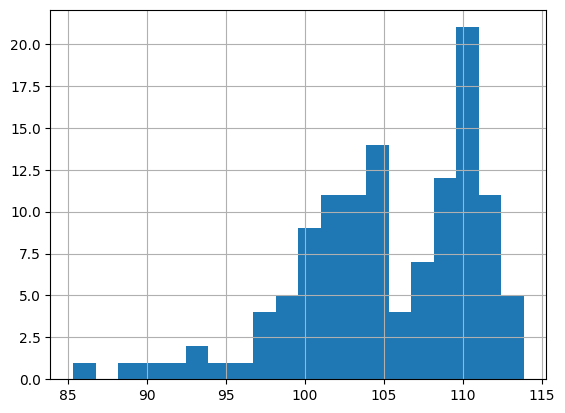

In [9]:
max_hi_per_day['heat_index'].hist(bins=20)

In [10]:
df.to_csv("phoenix_observations_2024_summer.csv", index=False)